# *(Li, et. al, 2017)*: Unified Thalamus Oscillation Model

Implementation of the model:

- Li, Guoshi, Craig S. Henriquez, and Flavio Fröhlich. "Unified
  thalamic model generates multiple distinct oscillations with
  state-dependent entrainment by stimulation." PLoS computational
  biology 13.10 (2017): e1005797.

In [1]:
from typing import Dict
import matplotlib.pyplot as plt
import numpy as np

import brainpy as bp
import brainpy.math as bm
from brainpy import channels, synapses, synouts, synplast


## HTC neuron

In [2]:
class HTC(bp.CondNeuGroup):
  def __init__(self, size, gKL=0.01, V_initializer=bp.init.OneInit(-65.), ):
    gL = 0.01 if size == 1 else bp.init.Uniform(0.0075, 0.0125)
    IL = channels.IL(size, g_max=gL, E=-70)
    IKL = channels.IKL(size, g_max=gKL)
    INa = channels.INa_Ba2002(size, V_sh=-30)
    IDR = channels.IKDR_Ba2002(size, V_sh=-30., phi=0.25)
    Ih = channels.Ih_HM1992(size, g_max=0.01, E=-43)

    ICaL = channels.ICaL_IS2008(size, g_max=0.5)
    IAHP = channels.IAHP_De1994(size, g_max=0.3, E=-90.)
    ICaN = channels.ICaN_IS2008(size, g_max=0.5)
    ICaT = channels.ICaT_HM1992(size, g_max=2.1)
    ICaHT = channels.ICaHT_HM1992(size, g_max=3.0)
    Ca = channels.CalciumDetailed(size, C_rest=5e-5, tau=10., d=0.5, ICaL=ICaL,
                                  IAHP=IAHP, ICaN=ICaN, ICaT=ICaT, ICaHT=ICaHT)

    super(HTC, self).__init__(size, A=2.9e-4, V_initializer=V_initializer, V_th=20.,
                              IL=IL, IKL=IKL, INa=INa, IDR=IDR, Ih=Ih, Ca=Ca)



## RTC neuron

In [3]:
class RTC(bp.CondNeuGroup):
  def __init__(self, size, gKL=0.01, V_initializer=bp.init.OneInit(-65.), ):
    gL = 0.01 if size == 1 else bp.init.Uniform(0.0075, 0.0125)
    IL = channels.IL(size, g_max=gL, E=-70)
    IKL = channels.IKL(size, g_max=gKL)
    INa = channels.INa_Ba2002(size, V_sh=-40)
    IDR = channels.IKDR_Ba2002(size, V_sh=-40, phi=0.25)
    Ih = channels.Ih_HM1992(size, g_max=0.01, E=-43)

    ICaL = channels.ICaL_IS2008(size, g_max=0.3)
    IAHP = channels.IAHP_De1994(size, g_max=0.1, E=-90.)
    ICaN = channels.ICaN_IS2008(size, g_max=0.6)
    ICaT = channels.ICaT_HM1992(size, g_max=2.1)
    ICaHT = channels.ICaHT_HM1992(size, g_max=0.6)
    Ca = channels.CalciumDetailed(size, C_rest=5e-5, tau=10., d=0.5, ICaL=ICaL,
                                  IAHP=IAHP, ICaN=ICaN, ICaT=ICaT, ICaHT=ICaHT)

    super(RTC, self).__init__(size, A=2.9e-4, V_initializer=V_initializer, V_th=20.,
                              IL=IL, IKL=IKL, INa=INa, IDR=IDR, Ih=Ih, Ca=Ca)


## IN neuron

In [4]:
class IN(bp.CondNeuGroup):
  def __init__(self, size, gKL=0.01, V_initializer=bp.init.OneInit(-70.), ):
    gL = 0.01 if size == 1 else bp.init.Uniform(0.0075, 0.0125)
    IL = channels.IL(size, g_max=gL, E=-60)
    IKL = channels.IKL(size, g_max=gKL)
    INa = channels.INa_Ba2002(size, V_sh=-30)
    IDR = channels.IKDR_Ba2002(size, V_sh=-30, phi=0.25)
    Ih = channels.Ih_HM1992(size, g_max=0.05, E=-43)

    IAHP = channels.IAHP_De1994(size, g_max=0.2, E=-90.)
    ICaN = channels.ICaN_IS2008(size, g_max=0.1)
    ICaHT = channels.ICaHT_HM1992(size, g_max=2.5)
    Ca = channels.CalciumDetailed(size, C_rest=5e-5, tau=10., d=0.5,
                                  IAHP=IAHP, ICaN=ICaN, ICaHT=ICaHT)

    super(IN, self).__init__(size, A=1.7e-4, V_initializer=V_initializer, V_th=20.,
                             IL=IL, IKL=IKL, INa=INa, IDR=IDR, Ih=Ih, Ca=Ca)


## TRN neuron

In [5]:
class TRN(bp.CondNeuGroup):
  def __init__(self, size, gKL=0.01, V_initializer=bp.init.OneInit(-70.), ):
    gL = 0.01 if size == 1 else bp.init.Uniform(0.0075, 0.0125)
    IL = channels.IL(size, g_max=gL, E=-60)
    IKL = channels.IKL(size, g_max=gKL)
    INa = channels.INa_Ba2002(size, V_sh=-40)
    IDR = channels.IKDR_Ba2002(size, V_sh=-40)

    IAHP = channels.IAHP_De1994(size, g_max=0.2, E=-90.)
    ICaN = channels.ICaN_IS2008(size, g_max=0.2)
    ICaT = channels.ICaT_HP1992(size, g_max=1.3)
    Ca = channels.CalciumDetailed(size, C_rest=5e-5, tau=100., d=0.5,
                                  IAHP=IAHP, ICaN=ICaN, ICaT=ICaT)

    super(TRN, self).__init__(size, A=1.43e-4,
                              V_initializer=V_initializer, V_th=20.,
                              IL=IL, IKL=IKL, INa=INa, IDR=IDR, Ca=Ca)


## Thalamus network

In [6]:
class MgBlock(bp.SynOut):
  def __init__(self, E=0.):
    super(MgBlock, self).__init__()
    self.E = E

  def filter(self, g):
    V = self.master.post.V.value
    return g * (self.E - V) / (1 + bm.exp(-(V + 25) / 12.5))

In [7]:
class Thalamus(bp.Network):
  def __init__(
      self,
      g_input: Dict[str, float],
      g_KL: Dict[str, float],
      HTC_V_init=bp.init.OneInit(-65.),
      RTC_V_init=bp.init.OneInit(-65.),
      IN_V_init=bp.init.OneInit(-70.),
      RE_V_init=bp.init.OneInit(-70.),
  ):
    super(Thalamus, self).__init__()

    # populations
    self.HTC = HTC(size=(7, 7), gKL=g_KL['TC'], V_initializer=HTC_V_init)
    self.RTC = RTC(size=(12, 12), gKL=g_KL['TC'], V_initializer=RTC_V_init)
    self.RE = TRN(size=(10, 10), gKL=g_KL['RE'], V_initializer=IN_V_init)
    self.IN = IN(size=(8, 8), gKL=g_KL['IN'], V_initializer=RE_V_init)

    # noises
    self.poisson_HTC = bp.neurons.PoissonGroup(self.HTC.size, freqs=100)
    self.poisson_RTC = bp.neurons.PoissonGroup(self.RTC.size, freqs=100)
    self.poisson_IN = bp.neurons.PoissonGroup(self.IN.size, freqs=100)
    self.poisson_RE = bp.neurons.PoissonGroup(self.RE.size, freqs=100)
    self.noise2HTC = synapses.Exponential(self.poisson_HTC, self.HTC, bp.conn.One2One(),
                                          output=synouts.COBA(E=0.), tau=5.,
                                          g_max=g_input['TC'])
    self.noise2RTC = synapses.Exponential(self.poisson_RTC, self.RTC, bp.conn.One2One(),
                                          output=synouts.COBA(E=0.), tau=5.,
                                          g_max=g_input['TC'])
    self.noise2IN = synapses.Exponential(self.poisson_IN, self.IN, bp.conn.One2One(),
                                         output=synouts.COBA(E=0.), tau=5.,
                                         g_max=g_input['IN'])
    self.noise2RE = synapses.Exponential(self.poisson_RE, self.RE, bp.conn.One2One(),
                                         output=synouts.COBA(E=0.), tau=5.,
                                         g_max=g_input['RE'])

    # HTC cells were connected with gap junctions
    self.gj_HTC = synapses.GapJunction(self.HTC, self.HTC,
                                       bp.conn.ProbDist(dist=2., prob=0.3, ),
                                       comp_method='sparse',
                                       g_max=1e-2)

    # HTC provides feedforward excitation to INs
    self.HTC2IN_ampa = synapses.AMPA(self.HTC, self.IN, bp.conn.FixedProb(0.3),
                                     delay_step=int(2 / bm.get_dt()),
                                     stp=synplast.STD(tau=700, U=0.07),
                                     alpha=0.94,
                                     beta=0.18,
                                     g_max=6e-3)
    self.HTC2IN_nmda = synapses.AMPA(self.HTC, self.IN, bp.conn.FixedProb(0.3),
                                     delay_step=int(2 / bm.get_dt()),
                                     stp=synplast.STD(tau=700, U=0.07),
                                     output=MgBlock(),
                                     alpha=1.,
                                     beta=0.0067,
                                     g_max=3e-3)

    # INs delivered feedforward inhibition to RTC cells
    self.IN2RTC = synapses.GABAa(self.IN, self.RTC, bp.conn.FixedProb(0.3),
                                 delay_step=int(2 / bm.get_dt()),
                                 stp=synplast.STD(tau=700, U=0.07),
                                 output=synouts.COBA(E=-80),
                                 alpha=10.5,
                                 beta=0.166,
                                 g_max=3e-3)

    # 20% RTC cells electrically connected with HTC cells
    self.gj_RTC2HTC = synapses.GapJunction(self.RTC, self.HTC,
                                           bp.conn.ProbDist(dist=2., prob=0.3, pre_ratio=0.2),
                                           comp_method='sparse',
                                           g_max=1 / 300)

    # Both HTC and RTC cells sent glutamatergic synapses to RE neurons, while
    # receiving GABAergic feedback inhibition from the RE population
    self.HTC2RE_ampa = synapses.AMPA(self.HTC, self.RE, bp.conn.FixedProb(0.2),
                                     delay_step=int(2 / bm.get_dt()),
                                     stp=synplast.STD(tau=700, U=0.07),
                                     alpha=0.94,
                                     beta=0.18,
                                     g_max=4e-3)
    self.RTC2RE_ampa = synapses.AMPA(self.RTC, self.RE, bp.conn.FixedProb(0.2),
                                     delay_step=int(2 / bm.get_dt()),
                                     stp=synplast.STD(tau=700, U=0.07),
                                     alpha=0.94,
                                     beta=0.18,
                                     g_max=4e-3)
    self.HTC2RE_nmda = synapses.AMPA(self.HTC, self.RE, bp.conn.FixedProb(0.2),
                                     delay_step=int(2 / bm.get_dt()),
                                     stp=synplast.STD(tau=700, U=0.07),
                                     output=MgBlock(),
                                     alpha=1.,
                                     beta=0.0067,
                                     g_max=2e-3)
    self.RTC2RE_nmda = synapses.AMPA(self.RTC, self.RE, bp.conn.FixedProb(0.2),
                                     delay_step=int(2 / bm.get_dt()),
                                     stp=synplast.STD(tau=700, U=0.07),
                                     output=MgBlock(),
                                     alpha=1.,
                                     beta=0.0067,
                                     g_max=2e-3)
    self.RE2HTC = synapses.GABAa(self.RE, self.HTC, bp.conn.FixedProb(0.2),
                                 delay_step=int(2 / bm.get_dt()),
                                 stp=synplast.STD(tau=700, U=0.07),
                                 output=synouts.COBA(E=-80),
                                 alpha=10.5,
                                 beta=0.166,
                                 g_max=3e-3)
    self.RE2RTC = synapses.GABAa(self.RE, self.RTC, bp.conn.FixedProb(0.2),
                                 delay_step=int(2 / bm.get_dt()),
                                 stp=synplast.STD(tau=700, U=0.07),
                                 output=synouts.COBA(E=-80),
                                 alpha=10.5,
                                 beta=0.166,
                                 g_max=3e-3)

    # RE neurons were connected with both gap junctions and GABAergic synapses
    self.gj_RE = synapses.GapJunction(self.RE, self.RE,
                                      bp.conn.ProbDist(dist=2., prob=0.3, pre_ratio=0.2),
                                      comp_method='sparse',
                                      g_max=1 / 300)
    self.RE2RE = synapses.GABAa(self.RE, self.RE, bp.conn.FixedProb(0.2),
                                delay_step=int(2 / bm.get_dt()),
                                stp=synplast.STD(tau=700, U=0.07),
                                output=synouts.COBA(E=-70),
                                alpha=10.5, beta=0.166,
                                g_max=1e-3)

    # 10% RE neurons project GABAergic synapses to local interneurons
    # probability (0.05) was used for the RE->IN synapses according to experimental data
    self.RE2IN = synapses.GABAa(self.RE, self.IN, bp.conn.FixedProb(0.05, pre_ratio=0.1),
                                delay_step=int(2 / bm.get_dt()),
                                stp=synplast.STD(tau=700, U=0.07),
                                output=synouts.COBA(E=-80),
                                alpha=10.5, beta=0.166,
                                g_max=1e-3, )


## Simulation

In [8]:

states = {
  'delta': dict(g_input={'IN': 1e-4, 'RE': 1e-4, 'TC': 1e-4},
                g_KL={'TC': 0.035, 'RE': 0.03, 'IN': 0.01}),
  'spindle': dict(g_input={'IN': 3e-4, 'RE': 3e-4, 'TC': 3e-4},
                  g_KL={'TC': 0.01, 'RE': 0.02, 'IN': 0.015}),
  'alpha': dict(g_input={'IN': 1.5e-3, 'RE': 1.5e-3, 'TC': 1.5e-3},
                g_KL={'TC': 0., 'RE': 0.01, 'IN': 0.02}),
  'gamma': dict(g_input={'IN': 1.5e-3, 'RE': 1.5e-3, 'TC': 1.7e-2},
                g_KL={'TC': 0., 'RE': 0.01, 'IN': 0.02}),
}


In [9]:

def rhythm_const_input(amp, freq, length, duration, t_start=0., t_end=None, dt=None):
  if t_end is None: t_end = duration
  if length > duration:
    raise ValueError(f'Expected length <= duration, while we got {length} > {duration}')
  sec_length = 1e3 / freq
  values, durations = [0.], [t_start]
  for t in np.arange(t_start, t_end, sec_length):
    values.append(amp)
    if t + length <= t_end:
      durations.append(length)
      values.append(0.)
      if t + sec_length <= t_end:
        durations.append(sec_length - length)
      else:
        durations.append(t_end - t - length)
    else:
      durations.append(t_end - t)
  values.append(0.)
  durations.append(duration - t_end)
  return bp.inputs.section_input(values=values, durations=durations, dt=dt, )



In [10]:

def try_trn_neuron():
  trn = TRN(1)
  I, length = bp.inputs.section_input(values=[0, -0.05, 0],
                                      durations=[100, 100, 500],
                                      return_length=True,
                                      dt=0.01)
  runner = bp.DSRunner(trn,
                       monitors=['V'],
                       inputs=['input', I, 'iter'],
                       dt=0.01)
  runner.run(length)

  bp.visualize.line_plot(runner.mon.ts, runner.mon.V, show=True)



  0%|          | 0/70000 [00:00<?, ?it/s]

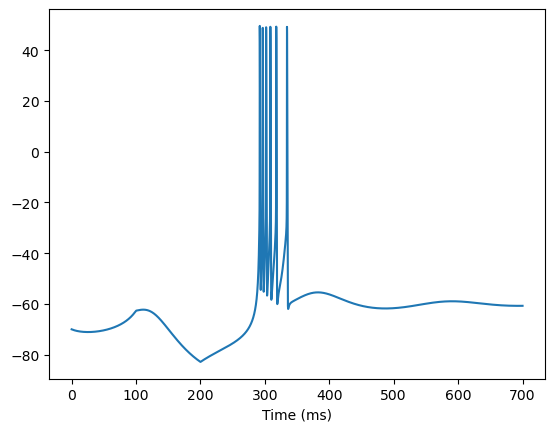

In [11]:
try_trn_neuron()

In [12]:

def try_network(state='delta'):
  duration = 3e3
  net = Thalamus(
    IN_V_init=bp.init.OneInit(-70.),
    RE_V_init=bp.init.OneInit(-70.),
    HTC_V_init=bp.init.OneInit(-80.),
    RTC_V_init=bp.init.OneInit(-80.),
    **states[state],
  )
  net.reset()

  currents = rhythm_const_input(2e-4, freq=4., length=10.,
                                duration=duration,
                                t_end=2e3, t_start=1e3)
  plt.plot(currents)
  plt.title('Current')
  plt.show()

  runner = bp.DSRunner(
    net,
    monitors=['HTC.spike', 'RTC.spike', 'RE.spike', 'IN.spike',
              'HTC.V', 'RTC.V', 'RE.V', 'IN.V', ],
    inputs=[('HTC.input', currents, 'iter'),
            ('RTC.input', currents, 'iter'),
            ('IN.input', currents, 'iter')],
  )
  runner.run(duration)

  fig, gs = bp.visualize.get_figure(4, 2, 2, 5)
  fig.add_subplot(gs[0, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon.get('HTC.V'), ylabel='HTC', xlim=(0, duration))
  fig.add_subplot(gs[1, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon.get('RTC.V'), ylabel='RTC', xlim=(0, duration))
  fig.add_subplot(gs[2, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon.get('IN.V'), ylabel='IN', xlim=(0, duration))
  fig.add_subplot(gs[3, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon.get('RE.V'), ylabel='RE', xlim=(0, duration))

  fig.add_subplot(gs[0, 1])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon.get('HTC.spike'), xlim=(0, duration))
  fig.add_subplot(gs[1, 1])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon.get('RTC.spike'), xlim=(0, duration))
  fig.add_subplot(gs[2, 1])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon.get('IN.spike'), xlim=(0, duration))
  fig.add_subplot(gs[3, 1])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon.get('RE.spike'), xlim=(0, duration))

  plt.show()


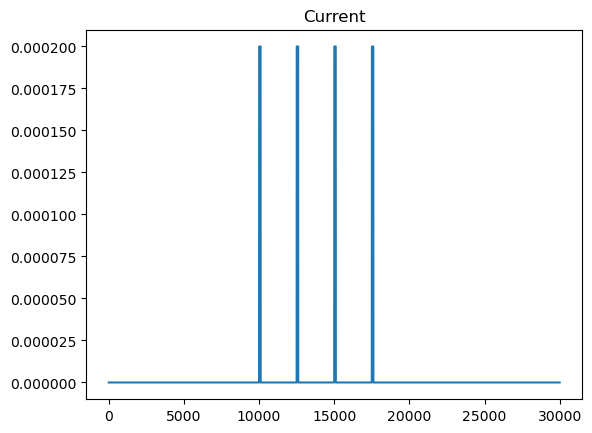

  0%|          | 0/30000 [00:00<?, ?it/s]

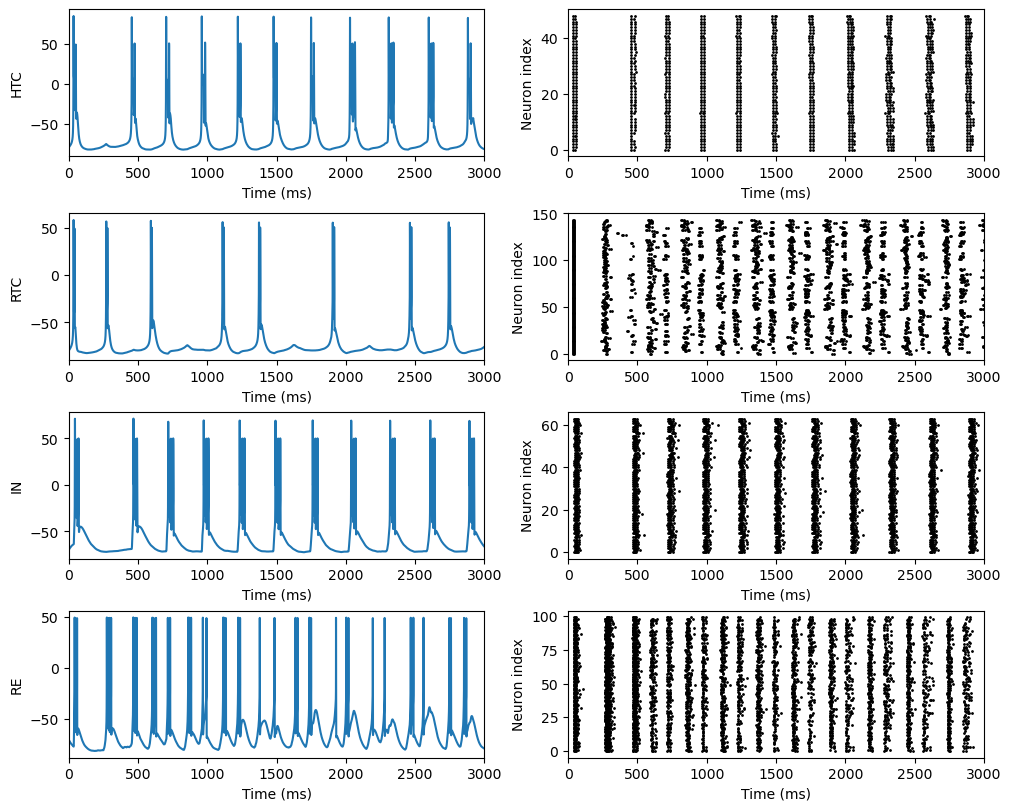

In [13]:
try_network()